## Computing the SVD

We now discuss an algorithm for computing the SVD based on the derivation in the previous lecture.  We use the QR algorithm to compute the singular values.  We first note that the QR factorization can be extended to work on singular $n \times n$ matrices $A$, but $r_{ii} = 0$ for some $i$.

In [1]:
A = rand(5); A(:,2) = A(:,1); A(:,4) = A(:,5);
[Q,R] = QRsing(A,1e-12)
norm(Q'*Q - eye(5))
norm(A-Q*R)

Q =

    0.4927    0.4918   -0.1741    0.3945   -0.5740
    0.5478    0.2346    0.4822   -0.6362    0.0876
    0.0768   -0.2659    0.7818    0.5586   -0.0151
    0.5523   -0.0871   -0.2962    0.3163    0.7068
    0.3824   -0.7905   -0.1955   -0.1661   -0.4038


R =

    1.6536    1.6536    1.2569    1.1833    1.1833
         0    0.0000   -0.6241   -0.5128   -0.5128
         0         0    0.8886    0.1575    0.1575
         0         0         0    0.8930    0.8930
         0         0         0         0    0.0000


ans =

   3.8867e-14


ans =

   3.9435e-16


This allows the QR eigenvalue algorithm to find zero eigenvalues.

In [2]:
A = rand(5); A(:,2) = A(:,1); A(:,4) = A(:,5); A = A'*A;
QRalg(A,100,1e-12)'

QR completed in 50 iterations
ans =

    8.7756    0.5472    0.2931    0.0000    0.0000


We can also have the QR algorithm return eigenvectors.

In [3]:
m = 7; n = 5;
A = randn(7,5); A(:,2) = A(:,1); A(:,4) = A(:,5); AtA = A'*A;
[Q,D] = QRsys(AtA,1000,1e-13)
norm(AtA - Q*diag(D)*Q')

Maximum number of iterations reached, Nmax = 1000 

Q =

    0.5450    0.4218   -0.1584   -0.2274   -0.6696
    0.5450    0.4218   -0.1584    0.2274    0.6696
   -0.5164    0.7907    0.3287   -0.0000    0.0000
   -0.2639    0.0973   -0.6487   -0.6696    0.2274
   -0.2639    0.0973   -0.6487    0.6696   -0.2274


D =

   17.9542
    7.8598
    4.0164
   -0.0000
   -0.0000


ans =

   2.9203e-14


We can now build up $V$ and $\Sigma$:

In [4]:
V = Q;
sv = real(sqrt(D));
S = [diag(sv); zeros(m-n,n) ] % this is Sigma  

S =

    4.2372         0         0         0         0
         0    2.8035         0         0         0
         0         0    2.0041         0         0
         0         0         0         0         0
         0         0         0         0         0
         0         0         0         0         0
         0         0         0         0         0


Then, we compute the (numerical) rank.

In [5]:
rank = 0;
for i = 1:n
   if S(i,i) < 1e-10
     break
   end
   rank = rank + 1;
end
rank

rank =

     3


Then we fill out $U$, adding appropriate orthogonal columns.

In [6]:
U = zeros(m);
for i = 1:rank
  U(:,i) = A*V(:,i)/S(i,i);
end

U(:,rank+1:end) = randn(m,m-rank);
for j = rank+1:m
  for i=1:j-1
    U(:,j) = U(:,j) - (U(:,i)'*U(:,j))*U(:,i);
  end
  U(:,j) = U(:,j)/norm(U(:,j));
end

Now, we test our factorization.

In [7]:
norm(A-U*S*V')
norm(U'*U - eye(length(U)))
norm(V'*V - eye(length(V)))

ans =

   7.9877e-15


ans =

   7.7066e-15


ans =

   5.3468e-13


## Using the SVD for image compression

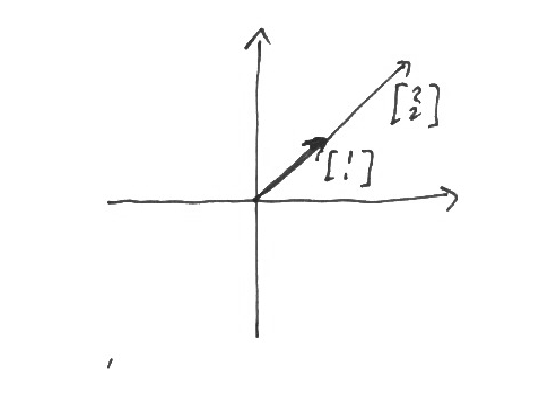

In [8]:
A = imread('demo.png');
A = rgb2gray(A);
imshow(A)

For this image, the first singular value is dominant.

In [9]:
[U,S,V] = svd(double(A));
S(1:5,1:5)

ans =

   1.0e+04 *

    8.4321         0         0         0         0
         0    0.2951         0         0         0
         0         0    0.2397         0         0
         0         0         0    0.2186         0
         0         0         0         0    0.2051


If we reconstruct the image using only the first singular value, we get a surprisingly good idea what the picture is.

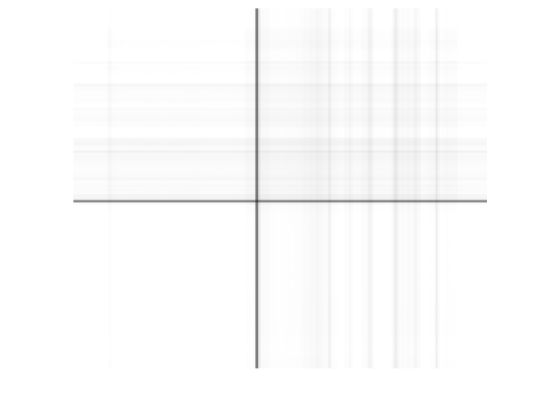

Compression ratio = 0.00598


In [10]:
k = 1; % A = U S V^T
W = V';
[m,n] = size(A);
B =  U(:,1:k)*S(1:k,1:k)*W(1:k,:);
B = uint8(B);
imshow(B)
fprintf('Compression ratio = %.5f', (m*k+k+n*k)/(m*n))

This required less then 1% of the storage required to store the full matrix.

Next, we look at the size of the singular values, relative to the top singular value:

In [11]:
diag(S(10:30,10:30))'/S(1,1) % Look at singular values 10 through 30, in relative size

ans =

  Columns 1 through 7

    0.0172    0.0162    0.0157    0.0149    0.0145    0.0143    0.0135

  Columns 8 through 14

    0.0122    0.0116    0.0109    0.0106    0.0099    0.0098    0.0096

  Columns 15 through 21

    0.0091    0.0088    0.0080    0.0078    0.0078    0.0075    0.0074


The 20th singular value is less than 1% of the magnitude of the top singular value.  So, we will chop there and see what image we reconstruct.

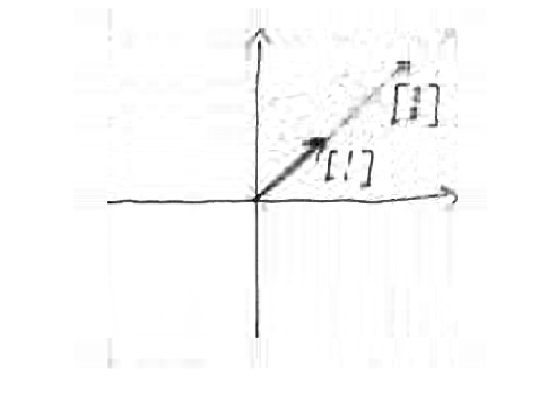

Compression ratio = 0.11955


In [12]:
k = 20; % A = U S V^T
W = V';
[m,n] = size(A);
B =  U(:,1:k)*S(1:k,1:k)*W(1:k,:);
B = uint8(B);
imshow(B)
fprintf('Compression ratio = %.5f', (m*k+k+n*k)/(m*n))

With just over 10% of the storage, we can compress the image so that it is at least recognizable.  There are some issues that affect the true amount of storage.  These are related to the fact that the original image was an integer matrix and $U,V,S$ are now double precision numbers.  Whether justified, or not, we ignore that here for simplicity.